<a href="https://colab.research.google.com/github/9M3a1h3d9i9/Ames-housing-Ensemble-learning/blob/main/Copy_of_Ensemble_Analysis_and_Predict(housing_price).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In the name of GOD
#
Project 5
# Winter 1403

# Mohammad Mahdi Shafighi

#

## import needed lib

In [ ]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV ##
from sklearn.preprocessing import StandardScaler, OneHotEncoder ##

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer ##
from sklearn.compose import ColumnTransformer ##

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, AdaBoostRegressor ##
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import root_mean_squared_error ##

import joblib

import matplotlib.pyplot as plt ##
import seaborn as sns ##

# Build Complete Pipeline


## Step 1: loead dataset


In [ ]:
def load_data(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"The file at {filepath} does not exist.")
    return pd.read_csv(filepath)

## Step 2: Data Cleaning


In [ ]:
def clean_data(df):
    df = df.drop_duplicates()
    # df = df.fillna(df.median())  # Impute missing values with median
    imputer = SimpleImputer(strategy='median') ##
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns) ##


    df.dropna(inplace=True) ##
    # df = df.drop_duplicates()

    return df

In [ ]:
def clean_data(df):
    df = df.drop_duplicates()

    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=['number']).columns
    categorical_cols = df.select_dtypes(exclude=['number']).columns

    # Create imputers for numerical and categorical columns
    numerical_imputer = SimpleImputer(strategy='median')
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    # Apply imputers to respective columns
    df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])
    df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

    df.dropna(inplace=True)

    return df

## Step 3: Exploratory Data Analysis (E D A)

we Assumes 'target' columns is existed.

* Add visualizations
* Scatter plot for two features vs. the target
* Calculate Corr Matrix

In [ ]:
def eda_summary(df, target_column):
    print("Data Summary:\n", df.describe())
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nClass Distribution:\n", df[target_column].value_counts())


    plt.figure(figsize=(12, 6))
    sns.histplot(df[target_column], kde=True)
    plt.title('Distribution of Target Variable')
    plt.show()

    # Convert to numeric before calculating correlation, handling errors
    numerical_df = df.select_dtypes(include=np.number)
    # correlation_matrix = df.corr() #--> have error from nonnumerical
    correlation_matrix = numerical_df.corr() ##
    print("\nCorrelation Matrix : \n", correlation_matrix) ##

    plt.figure(figsize=(20, 18)) ## 12, 10    16, 14    18, 16
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()


    if 'GrLivArea' in df.columns and 'TotalBsmtSF' in df.columns and target_column in df.columns:
      plt.figure(figsize=(8, 6))
      sns.scatterplot(x='GrLivArea', y=target_column, data=df)
      plt.title('GrLivArea vs. SalePrice')
      plt.show()

      plt.figure(figsize=(8, 6))
      sns.scatterplot(x='TotalBsmtSF', y=target_column, data=df)
      plt.title('TotalBsmtSF vs. SalePrice')
      plt.show()

## Step 4: Feature Engineering
* Example: Creating new feature based on existing data

add new change :

( Next version)
*Drop features with low correlation (fixed threshold = 0.1)
*target variable is the last column in the corr matrix  

In [ ]:
def feature_engineering(df):

    if 'GrLivArea' in df.columns and 'TotalBsmtSF' in df.columns:
        df['TotalLivingArea'] = df['GrLivArea'] + df['TotalBsmtSF']
    return df

## Step 5: Data Preprocessing
` Preprocesses the data: encoding, splitting, scaling, etc.`

* Separate deatures and target
* Identify categorical adn numerical columns
* define transromers
* Split the data


In [ ]:
def preprocess_data(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column]

    categorical_cols = X.select_dtypes(include=['object']).columns
    numerical_cols = X.select_dtypes(include=['number']).columns

    numerical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, preprocessor

## Step 6 : Model Selectoin

### Define the ensembele models for Regression:

* Bagging
* Boosting
* Stacking

In [ ]:
def create_ensemble_models():
    bagging_model = RandomForestRegressor(random_state=42)
    boosting_model = GradientBoostingRegressor(random_state=42)
    stacking_model = StackingRegressor(
        estimators=[('rf', RandomForestRegressor(random_state=42)), ('gb', GradientBoostingRegressor(random_state=42))],
        final_estimator=AdaBoostRegressor(random_state=42)
    )
    return bagging_model, boosting_model, stacking_model

# Step 7: Model Training and Evaluation
* Trains
* Evaluates multiple models
* Save model

In [ ]:
def train_and_evaluate(models, X_train, X_test, y_train, y_test, preprocessor):
    for model_name, model in models.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        print(f"\nModel: {model_name}")
        print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
        print("Root Mean Squared Error (RMSE)", root_mean_squared_error(y_test, y_pred))
        print(" - - - - - - - - - - - - - - - - - - - - - - - - - -")
        print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
        print("R² Score:", r2_score(y_test, y_pred))



        joblib.dump(pipeline, f"{model_name}_pipeline.pkl")
        print(f"Model saved as {model_name}_pipeline.pkl")

# Main Function

* Load data

* Clean data

* EDA

* Feature Engineering

* Preprocessing

* Define ensemble models

* Train and evaluate models

In [ ]:
def main(filepath, target_column):
  df = load_data(filepath)
  df = clean_data(df)
  eda_summary(df, target_column)
  df = feature_engineering(df)

  X_train, X_test, y_train, y_test, preprocessor = preprocess_data(df, target_column)
  bagging_model, boosting_model, stacking_model = create_ensemble_models()
  models = {
      'Bagging': bagging_model,
      'Boosting': boosting_model,
      'Stacking': stacking_model
  }

  train_and_evaluate(models, X_train, X_test, y_train, y_test, preprocessor)

# Use and Analysis models


Data Summary:
                 PID  MS SubClass  Lot Frontage       Lot Area  Overall Qual  \
count  2.930000e+03  2930.000000   2930.000000    2930.000000   2930.000000   
mean   7.144645e+08    57.387372     69.019795   10147.921843      6.094881   
std    1.887308e+08    42.638025     21.326422    7880.017759      1.411026   
min    5.263011e+08    20.000000     21.000000    1300.000000      1.000000   
25%    5.284770e+08    20.000000     60.000000    7440.250000      5.000000   
50%    5.354536e+08    50.000000     68.000000    9436.500000      6.000000   
75%    9.071811e+08    70.000000     78.000000   11555.250000      7.000000   
max    1.007100e+09   190.000000    313.000000  215245.000000     10.000000   

       Overall Cond   Year Built  Year Remod/Add  Mas Vnr Area  BsmtFin SF 1  \
count   2930.000000  2930.000000     2930.000000   2930.000000   2930.000000   
mean       5.563140  1971.356314     1984.266553    101.096928    442.604778   
std        1.111537    30.245361 

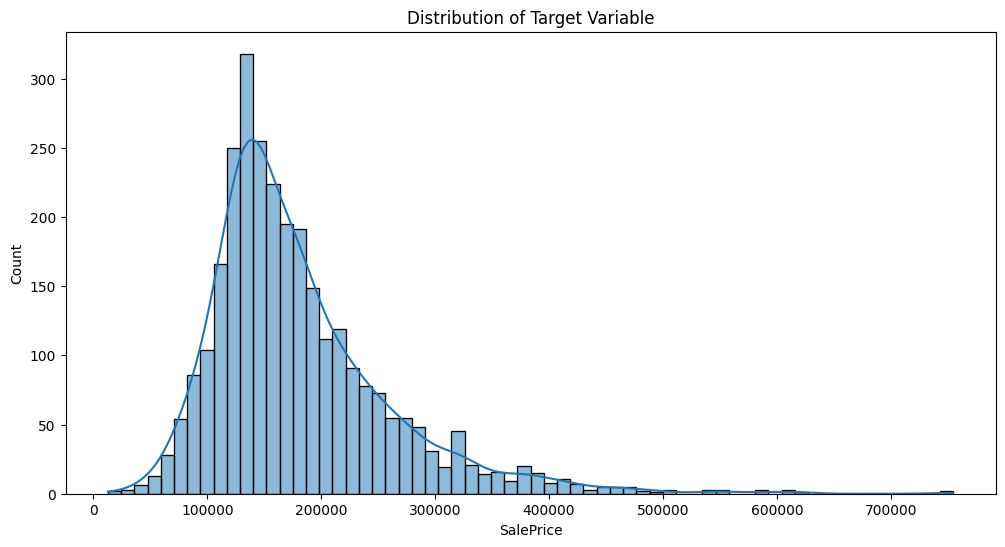


Correlation Matrix : 
                       PID  MS SubClass  Lot Frontage  Lot Area  Overall Qual  \
PID              1.000000    -0.001281     -0.087894  0.034868     -0.263147   
MS SubClass     -0.001281     1.000000     -0.391497 -0.204613      0.039419   
Lot Frontage    -0.087894    -0.391497      1.000000  0.362758      0.198917   
Lot Area         0.034868    -0.204613      0.362758  1.000000      0.097188   
Overall Qual    -0.263147     0.039419      0.198917  0.097188      1.000000   
Overall Cond     0.104451    -0.067349     -0.067140 -0.034759     -0.094812   
Year Built      -0.343388     0.036579      0.114341  0.023258      0.597027   
Year Remod/Add  -0.157111     0.043397      0.086139  0.021682      0.569609   
Mas Vnr Area    -0.225672     0.003634      0.201685  0.125950      0.423089   
BsmtFin SF 1    -0.098412    -0.060019      0.198161  0.191574      0.284091   
BsmtFin SF 2    -0.001245    -0.070847      0.039157  0.083198     -0.041122   
Bsmt Unf SF     

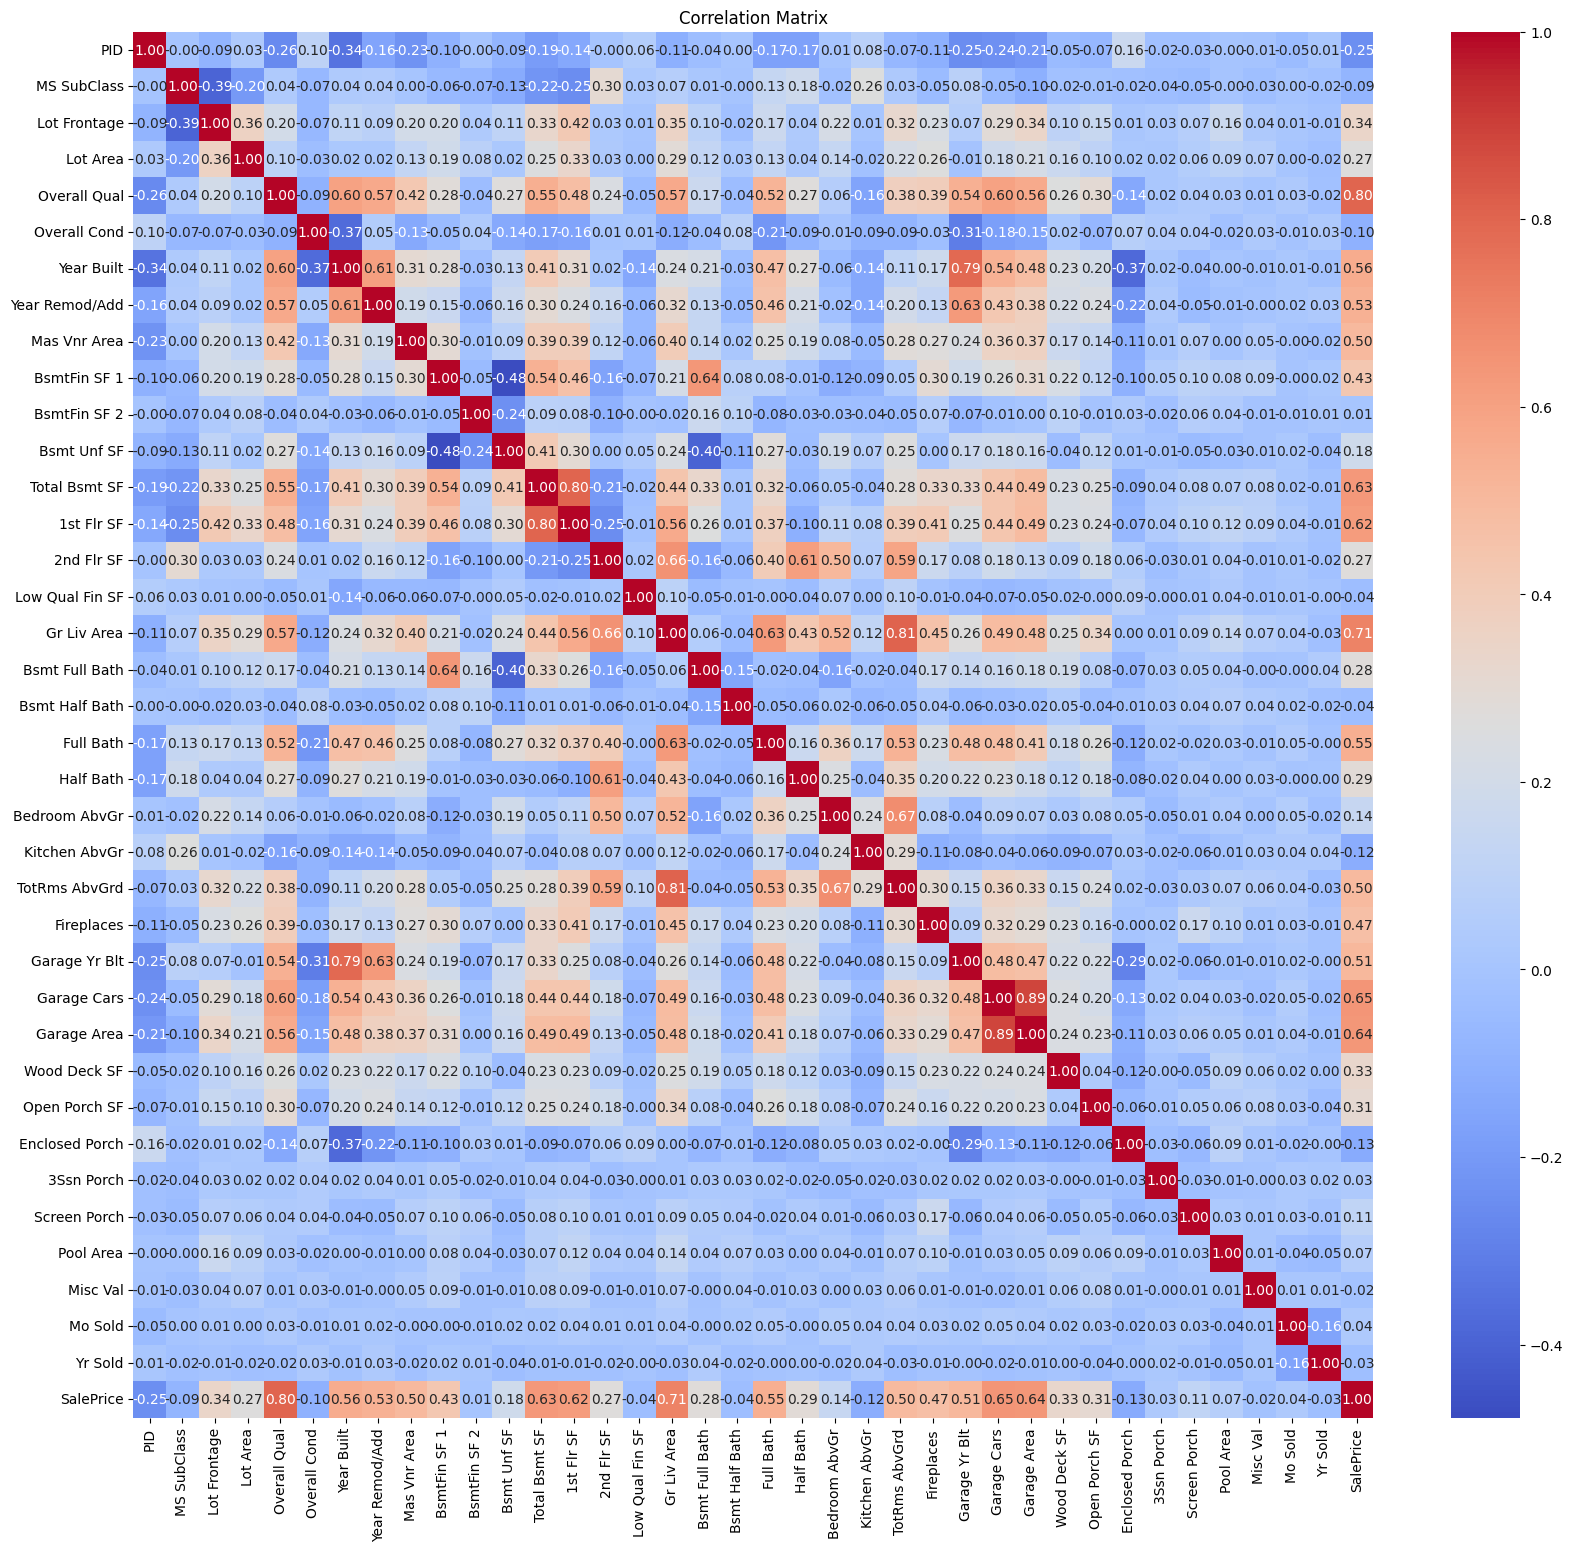


Model: Bagging
Mean Absolute Error (MAE): 15823.79866894198
Root Mean Squared Error (RMSE) 26404.82447825351
 - - - - - - - - - - - - - - - - - - - - - - - - - -
Mean Squared Error (MSE): 697214755.7273757
R² Score: 0.9130389039472276
Model saved as Bagging_pipeline.pkl

Model: Boosting
Mean Absolute Error (MAE): 15249.177597380278
Root Mean Squared Error (RMSE) 26583.13564014812
 - - - - - - - - - - - - - - - - - - - - - - - - - -
Mean Squared Error (MSE): 706663100.4625132
R² Score: 0.9118604457931188
Model saved as Boosting_pipeline.pkl

Model: Stacking
Mean Absolute Error (MAE): 17135.908708738054
Root Mean Squared Error (RMSE) 27230.18829174102
 - - - - - - - - - - - - - - - - - - - - - - - - - -
Mean Squared Error (MSE): 741483154.4036697
R² Score: 0.9075174653405885
Model saved as Stacking_pipeline.pkl


In [ ]:
if __name__ == "__main__":
    # dataset_path = "/content/AMES_Final.csv"  # Update with actual file path
    dataset_path = "/content/Ames_Housing_Data.csv" ## Update with actual file path
    target_col = "SalePrice"  # Update with actual target column name
    main(dataset_path, target_col)
